<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [6]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'cpu'

In [7]:
# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    
    return v.reshape((nz,nx))

# Apply mapping function to a nd slice array
def apply_along_3d(func, arr, axis=0):
    out = np.empty_like(arr)
    if axis==0:
        for i in range(arr.shape[0]):
            out[i,:,:] = func(arr[i,:,:])
    elif axis==1:
        for i in range(arr.shape[0]):
            out[:,i,:] = func(arr[:,i,:])
    elif axis==2:
        for i in range(arr.shape[0]):
            out[:,:,i] = func(arr[:,:,i])
    return out

# Define cost function
def cost(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])

In [8]:
# Import saved sample from prior

import pickle
# load data
filename = './data/u_ref'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# save data
# filename = './data/Q'
# outfile = open(filename, 'wb')
# pickle.dump(Q, outfile)
# outfile.close()

# Forward Propagation

In [9]:
# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 156
shape of p(z,x,t) = (200, 200, 800)


# Observe data

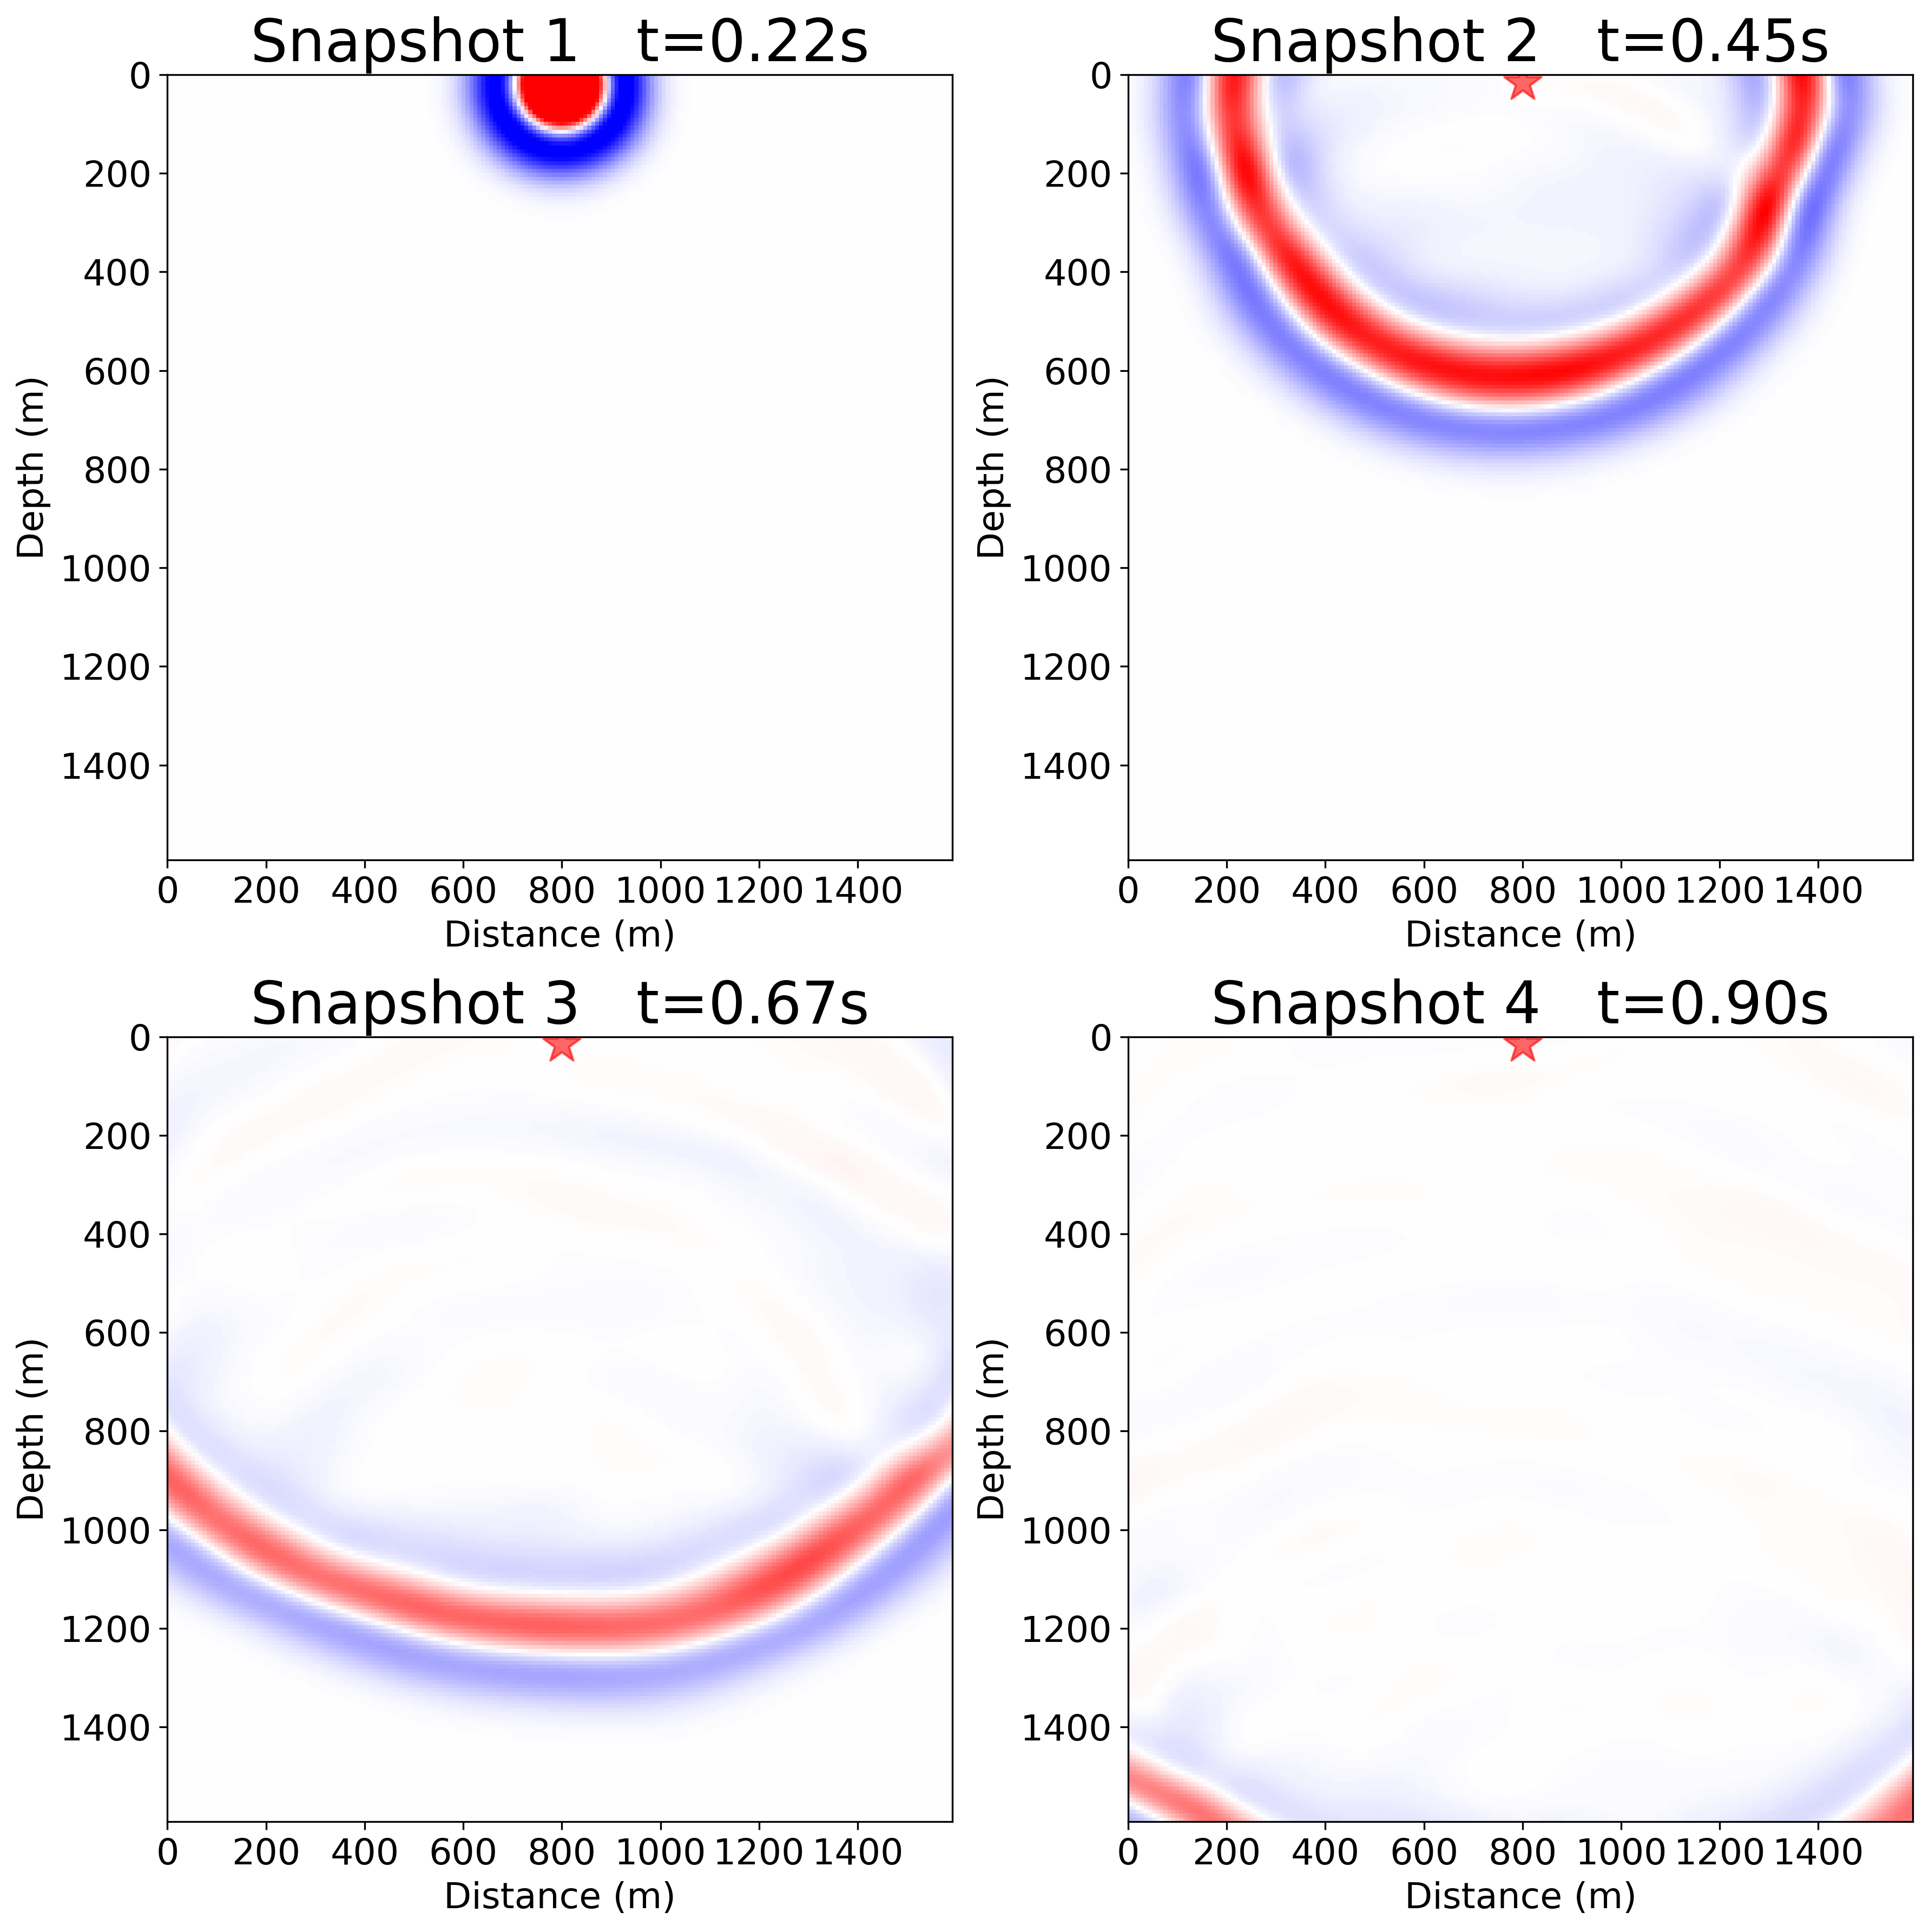

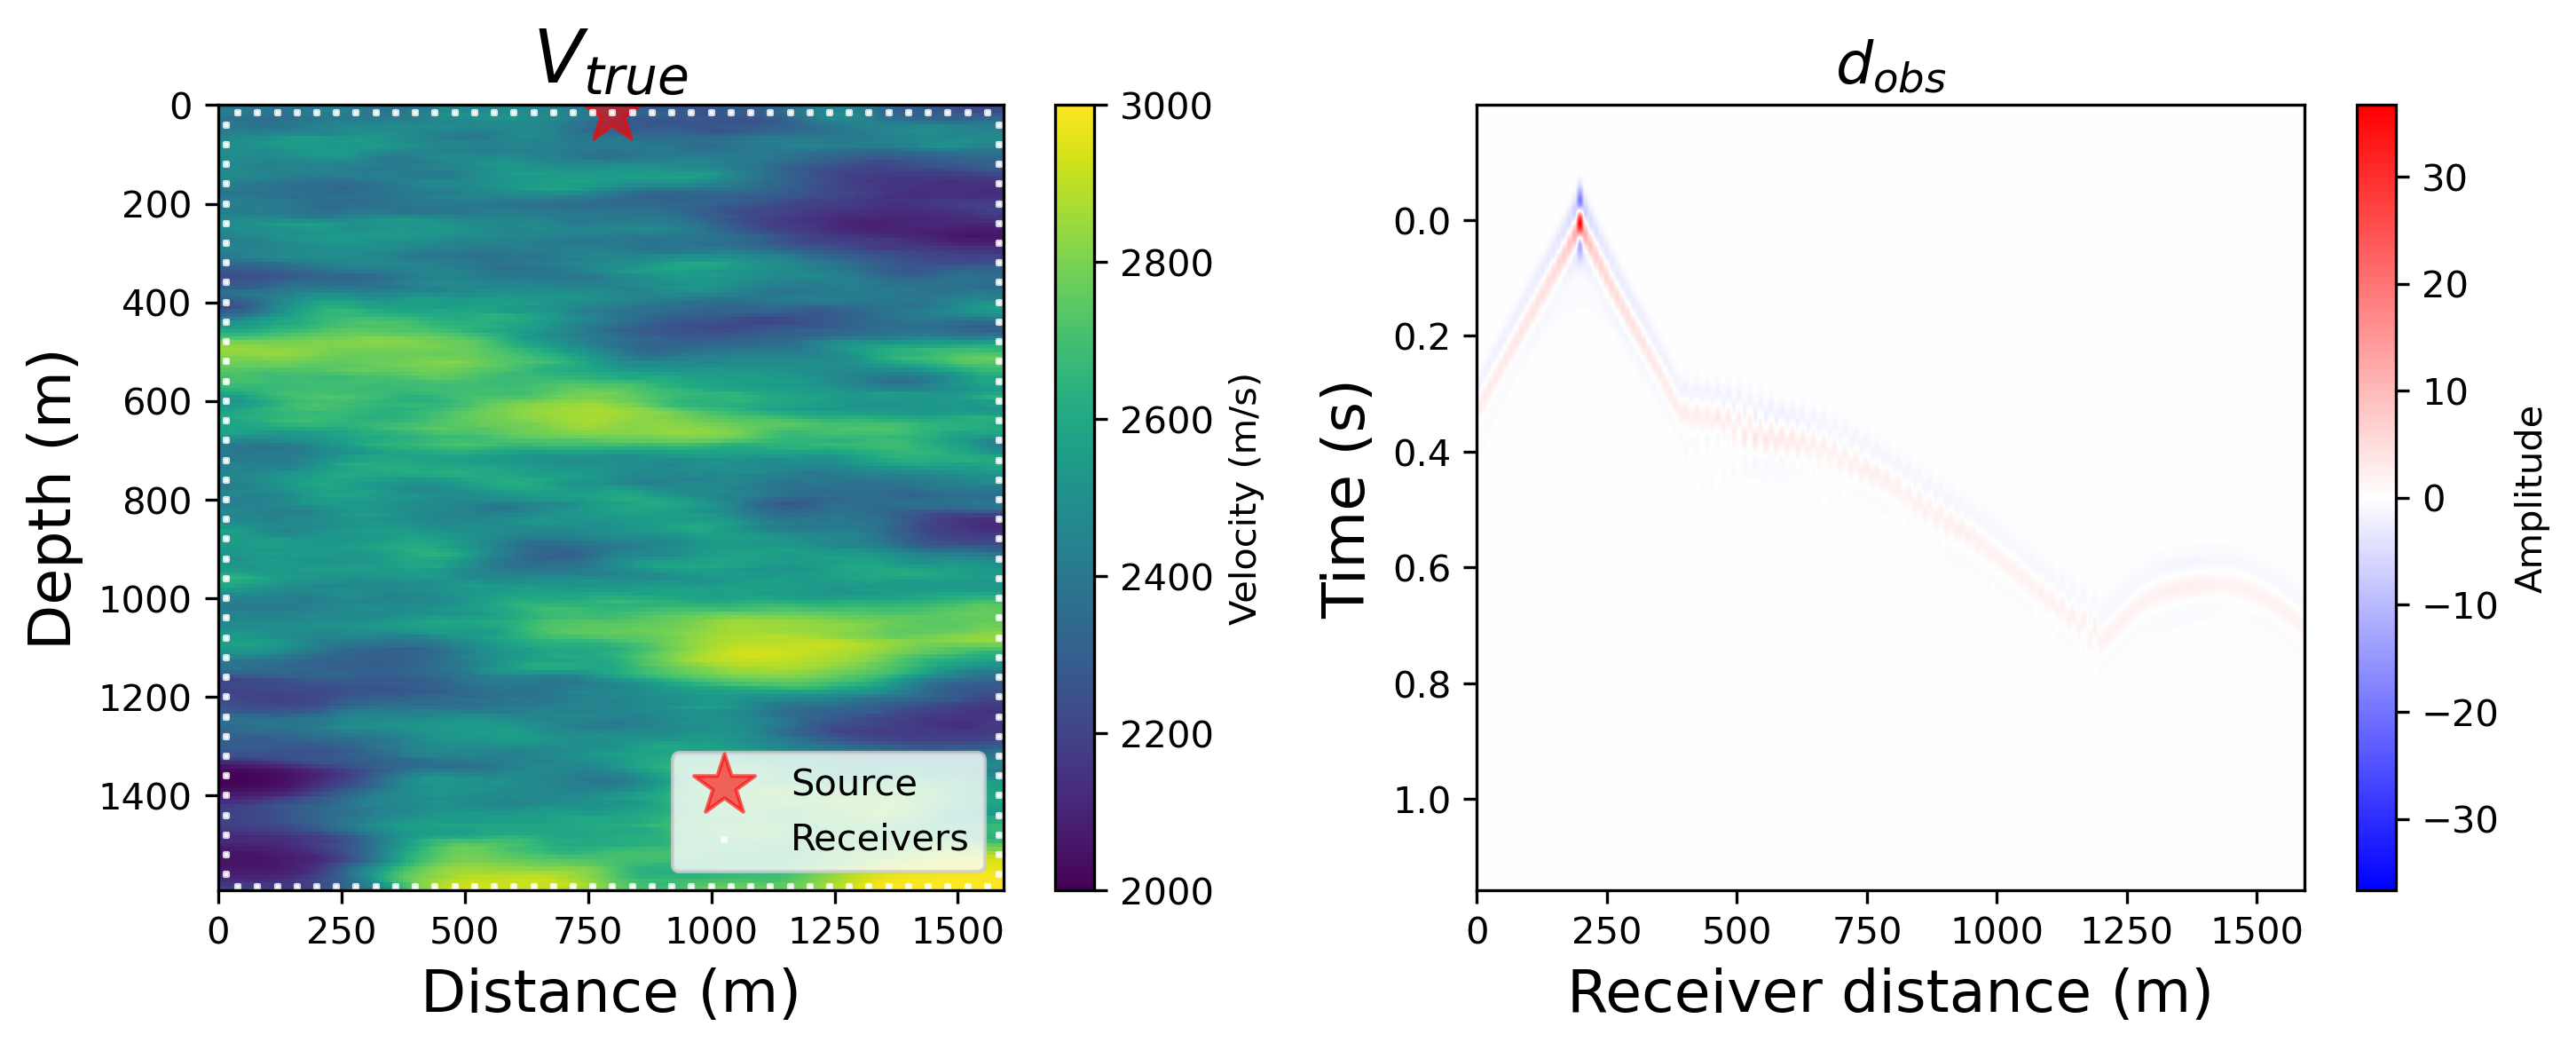

In [12]:
# std_noise = 1 # define the noise level
d_obs_no_noise = p[zxrec[0], zxrec[1], :]
d_obs = d_obs_no_noise
# d_obs = d_obs_no_noise + np.random.normal(0, std_noise, d_obs_no_noise.shape)
# print("Observation noise std =", std_noise)

labelsize = 16
plt.figure(figsize=(12,12), dpi=300,facecolor='white')
pmax = np.max(np.abs(p))/10.
for i in range(1,5):
    plt.subplot(2,2,i)
    t = int(i*(nt)) // 6
    plt.title('Snapshot '+str(i)+'   t='+str(t*dt)[:4]+'s',fontsize=labelsize+10)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.imshow(p[:,:,t], cmap='bwr', vmin=-pmax, \
                vmax=pmax, extent=[ax[0],ax[-1],az[-1],az[0]], \
                aspect='equal')
    plt.xlabel('Distance (m)', fontsize=labelsize)
    plt.ylabel('Depth (m)', fontsize=labelsize)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4),dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.8,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{true}$",fontsize=labelsize+4)
plt.subplot(1,2,2)
maxd = np.abs(d_obs).max()
plt.imshow(d_obs.T,cmap='bwr',vmin=-maxd,vmax=maxd,extent=[az[0], az[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
# plt.title("$d_{obs}$ with noise $\sigma_{Noise}$=%.2f  " % std_noise, fontsize=labelsize)
plt.title("$d_{obs}$", fontsize=labelsize)
plt.xlabel('Receiver distance (m)', fontsize=labelsize)
plt.ylabel('Time (s)', fontsize=labelsize)
plt.tight_layout()
plt.show()

# Display initial gradiant
# plt.figure(figsize=(3,3))
# u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
# v_init = f(u_init)   # Initial v
# # g_adj = gradiant(v_init,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
# plt.imshow(g_adj)
# plt.colorbar() 
# plt.title("Adjoint State gradiant")

# Minimization

In [ ]:
# minimize cost function
start = time.time()
u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = cost, 
               x0 = u_init.flatten(), 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':1000},
               callback=callback
              )
u_fwi = np.reshape(resi.x,(nz,nx))
v_fwi = f(u_fwi)
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

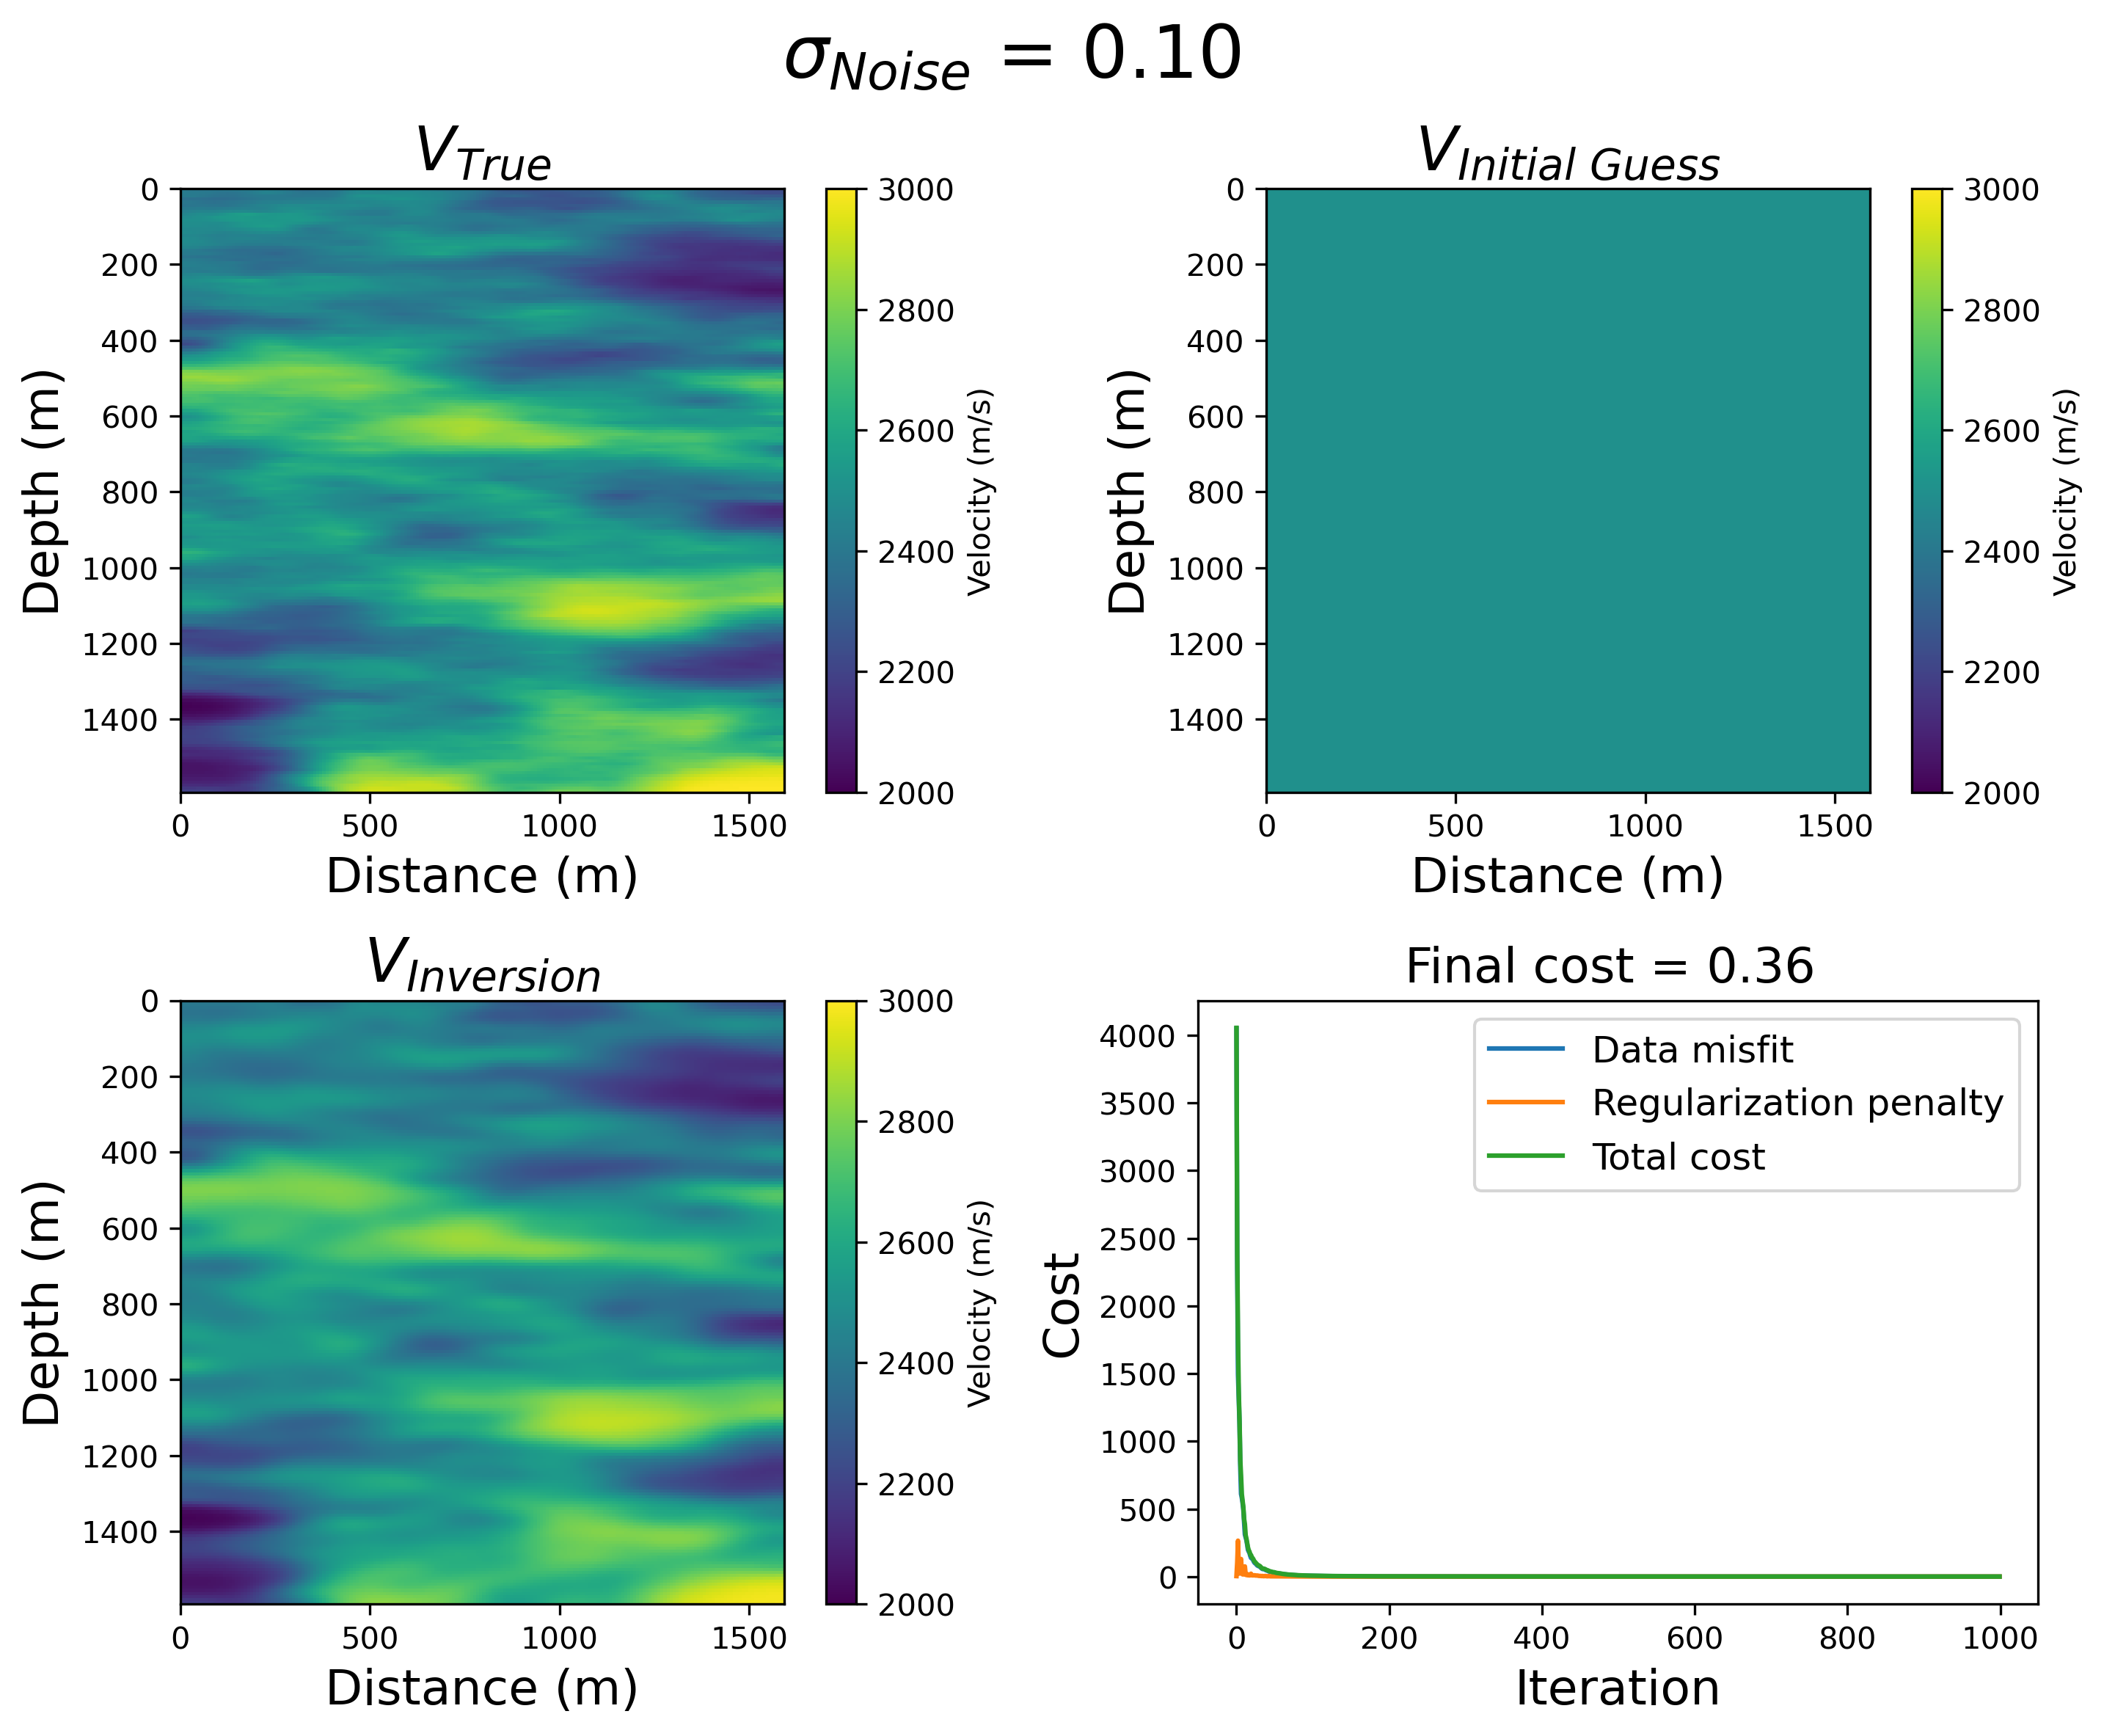

In [26]:
plt.figure(figsize=(10,8),dpi=300)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# MCMC

In [31]:
def metropolis_hastings_sampler(initial_state, n_iter, proposal_sigma, cost_func, *args):
    """
    Metropolis-Hastings MCMC sampler.
    """
    state = initial_state.copy()    # Initial state v0
    states = np.empty((n_iter, *state.shape))   # Save all states   
    states[0] = state
    log_probs = np.empty(n_iter)    # Save all log-probs
    log_probs[0] = cost_func(state, *args) # The log-post-prob of Initial state v0
    print("Start MCMC")
    
    for i in range(1, n_iter):
        print("Iteration", i, end=" ")
        # Propose a new state
        proposal = state + np.random.normal(scale=proposal_sigma, size=state.shape)
        
        # Calculate log probabilities
        log_prob_current = log_probs[i-1]
        log_prob_proposal = cost_func(proposal, *args)
        
        # Accept or reject proposal
        ratio = np.exp(log_prob_proposal - log_prob_current)

        # print(log_prob_proposal,log_prob_current,ratio)
        print("log_prob_proposal = %.2f" % log_prob_proposal,
               "log_prob_current = %.2f" % log_prob_current, 
                "Acceptance ratio = %.2f" % ratio, end=" ")
        '''
        Compare acceptance ratio with a random value [0,1)
        *This is done to introduce an element of randomness 
        into the decision process and to avoid getting stuck 
        in local maxima or minima of the posterior distribution
        '''
        if np.random.rand() < ratio:
            state = proposal.copy()
            log_prob_current = log_prob_proposal   
            print("Accepted")
        else: print("Rejected")
        '''
        *If rejected means that the proposed state is less favorable 
        than the current state, given the data and the model    
        '''
        # Save state and log probability
        states[i] = state
        log_probs[i] = log_prob_current
    
    return states, log_probs



def log_prob(u, d_obs, wsrc, zxsrc, zxrec, at, az, ax, next, device, alpha):
    # Calculate the "log posterior probability" of a given velocity model v:
    v = f(u)
    log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)/(std_noise**2)
    u = u.flatten()
    log_prior_prob = -0.5 * u.T.dot(Q.toarray()).dot(u)
    log_prob = log_likelihood + log_prior_prob
    print(log_likelihood, '+',log_prior_prob)
    # print("log probability = %.3f" % log_prob, end=" ")

    return log_prob

# Set the proposal standard deviation and the number of MCMC iterations:
proposal_sigma = 0.0001  # adjust as needed
n_iter = 1000  # adjust as needed

# Run MCMC
# initial_state = v_init.copy()
initial_state = u_fwi.copy()
samples, log_probs = metropolis_hastings_sampler(
    initial_state, n_iter, proposal_sigma, log_prob, 
    d_obs, wsrc, zxsrc, zxrec, at, az, ax, next, device, alpha)

# Extract posterior samples
burnin = 100  # adjust as needed
posterior_samples = samples[burnin:]

-90163.96828501023 + -969.0898510806888
Start MCMC
Iteration 1 -90166.01186878745 + -969.6573261964734
log_prob_proposal = -91135.67 log_prob_current = -91133.06 Acceptance ratio = 0.07 Rejected
Iteration 2 -90162.67265823341 + -969.4944214211145
log_prob_proposal = -91132.17 log_prob_current = -91133.06 Acceptance ratio = 2.44 Accepted
Iteration 3 -90162.08084086233 + -969.9004649299395
log_prob_proposal = -91131.98 log_prob_current = -91132.17 Acceptance ratio = 1.20 Accepted
Iteration 4 -90164.1828499576 + -970.2966398084219
log_prob_proposal = -91134.48 log_prob_current = -91131.98 Acceptance ratio = 0.08 Accepted
Iteration 5 -90166.24581416576 + -970.714924306144
log_prob_proposal = -91136.96 log_prob_current = -91134.48 Acceptance ratio = 0.08 Rejected
Iteration 6 -90162.3977860402 + -970.7298059363088
log_prob_proposal = -91133.13 log_prob_current = -91134.48 Acceptance ratio = 3.86 Accepted
Iteration 7 -90162.3241389109 + -971.1750345992585
log_prob_proposal = -91133.50 log_pro

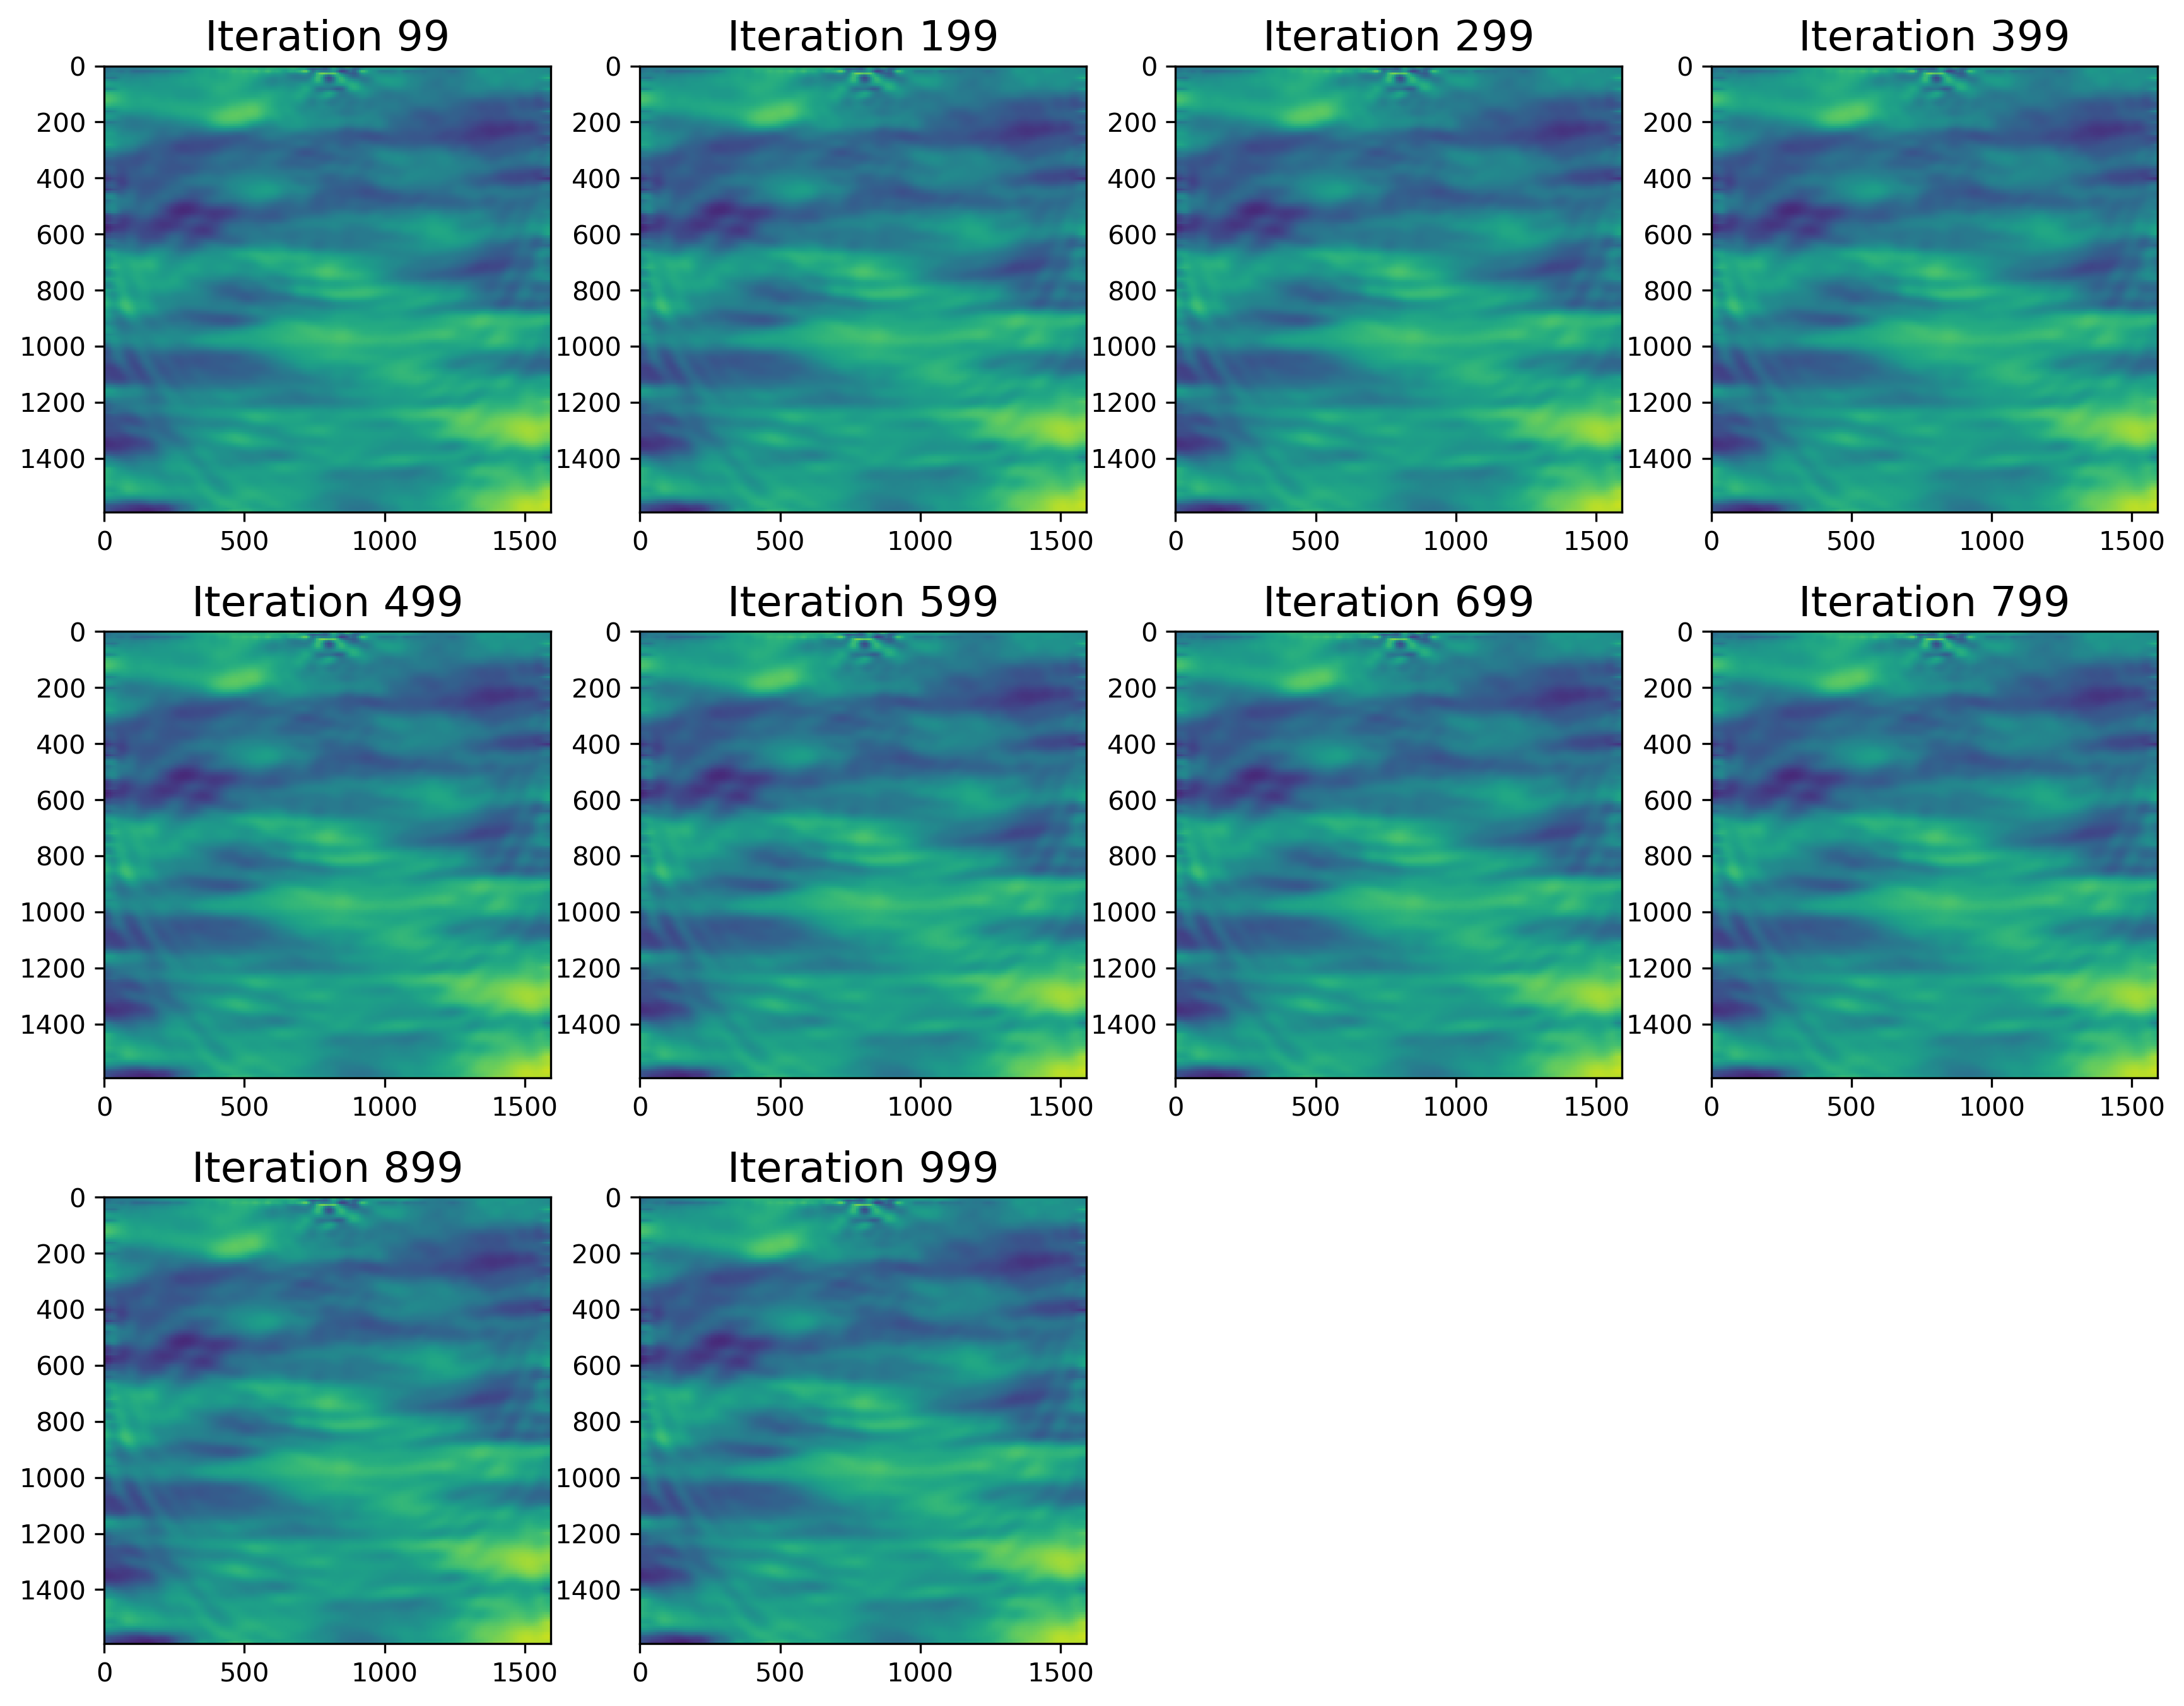

In [40]:
plt.figure(figsize=(14,11),dpi=300)
for i in range(10):
    plt.subplot(3,4,i+1) 
    num_sample = 100*(i+1)-1
    plt.imshow(f(samples[num_sample,:,:]),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
    plt.title("Iteration "+str(num_sample),fontsize=labelsize)
    # plt.tight_layout()

In [ ]:
def plot_posterior(chain, labels):
    n_chains, n_iter, n_params = chain.shape
    fig, axs = plt.subplots(n_params, 2, figsize=(8, 2*n_params), gridspec_kw={'width_ratios': [3, 1]})
    for i in range(n_params):
        axs[i,0].plot(chain[:,:,i].reshape(-1))
        axs[i,0].set_ylabel(labels[i])
        axs[i,0].grid(True)
        axs[i,1].hist(chain[:,:,i].reshape(-1), bins=50, orientation='horizontal')
        axs[i,1].grid(True)
    axs[n_params-1,0].set_xlabel('Iteration')
    axs[n_params-1,1].set_xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot the posterior samples
labels = ['Vp', 'Vs', 'Rho']
plot_posterior(posterior_samples, labels)

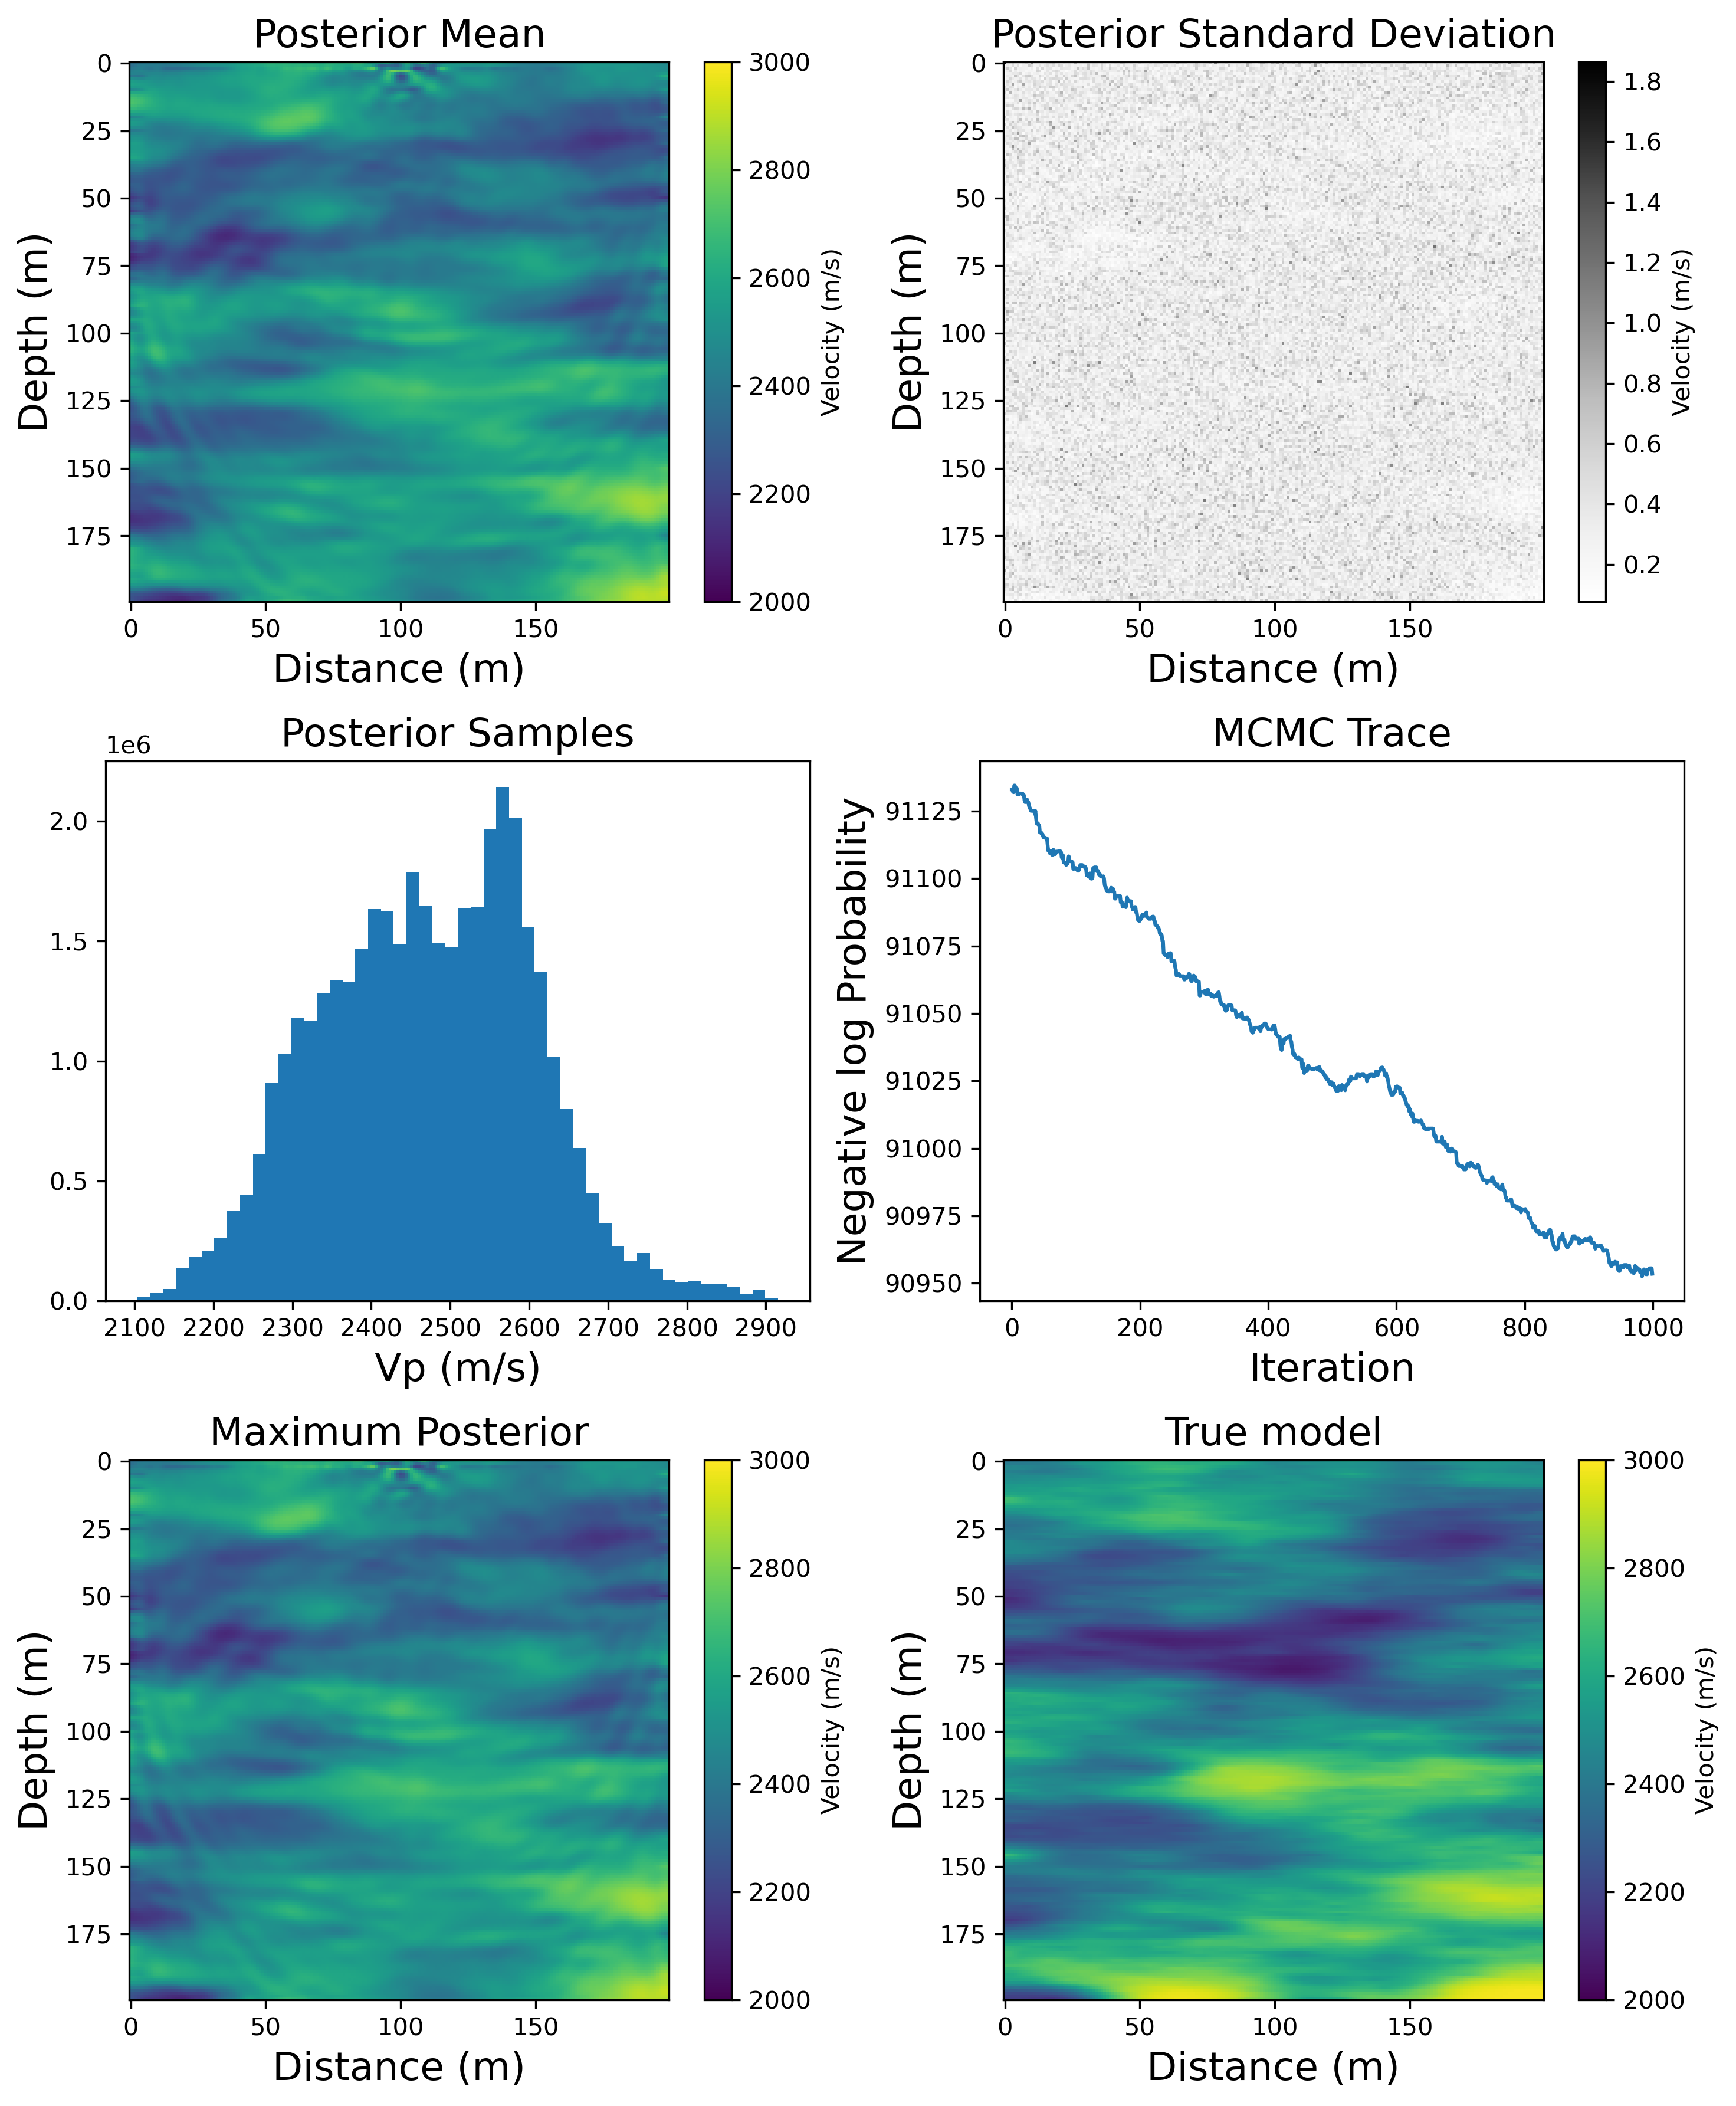

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape the posterior_samples array
n_samples = posterior_samples.shape[0]
posterior_v = apply_along_3d(f,posterior_samples,0)
# posterior_2d = posterior_samples.reshape(n_samples, nz*nx)

# Compute posterior mean and standard deviation
posterior_mean = np.mean(posterior_v, axis=0)
posterior_std = np.std(posterior_v, axis=0)

# Plot posterior mean and standard deviation
plt.figure(figsize=(10, 12),dpi=300)
plt.subplot(3, 2, 1)
plt.imshow(posterior_mean,vmin=2000,vmax=3000)
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title('Posterior Mean',fontsize=labelsize)

plt.subplot(3, 2, 2)
plt.imshow(posterior_std,cmap='Greys')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title('Posterior Standard Deviation',fontsize=labelsize)

# Plot posterior samples as histogram
plt.subplot(3, 2, 3)
plt.hist(posterior_v.flatten(), bins=50)
plt.xlabel('Vp (m/s)',fontsize=labelsize)
plt.title('Posterior Samples',fontsize=labelsize)

# Plot trace and autocorrelation
plt.subplot(3, 2, 4)
plt.plot(-log_probs)
plt.xlabel('Iteration',fontsize=labelsize)
plt.ylabel('Negative log Probability',fontsize=labelsize)
plt.title('MCMC Trace',fontsize=labelsize)

# Plot maximum posterior
plt.subplot(3, 2, 5)
max_index = np.argmax(log_probs)
plt.imshow(posterior_v[max_index,:,:],vmin=2000,vmax=3000)
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title('Maximum Posterior',fontsize=labelsize)

# Plot true model
plt.subplot(3, 2, 6)
plt.imshow(v_ref,vmin=2000,vmax=3000)
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title('True model',fontsize=labelsize)

# plt.subplot(1, 2, 2)
# plt.acorr(posterior_2d[:,0],maxlags=50)
# plt.title('Autocorrelation')

plt.tight_layout()



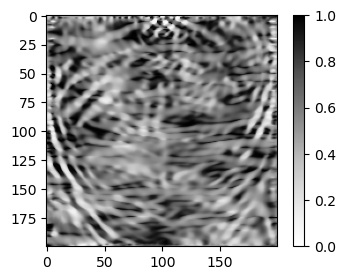

In [121]:
from matplotlib.colors import LightSource
plt.figure(figsize=(4,3))
ls = LightSource(azdeg=90, altdeg=30)
plt.imshow(ls.hillshade(v_fwi, vert_exag=0.1), cmap='Greys')
# rgb = ls.shade(v_fwi, cmap=plt.cm.jet, vert_exag=1, blend_mode='overlay',
#                 vmin=2000,vmax=3000)
# plt.imshow(rgb,cmap=plt.cm.jet,vmin=2000,vmax=3000)
# plt.imshow(v_fwi,cmap=plt.cm.jet,vmin=2000,vmax=3000)
plt.colorbar()
plt.show()

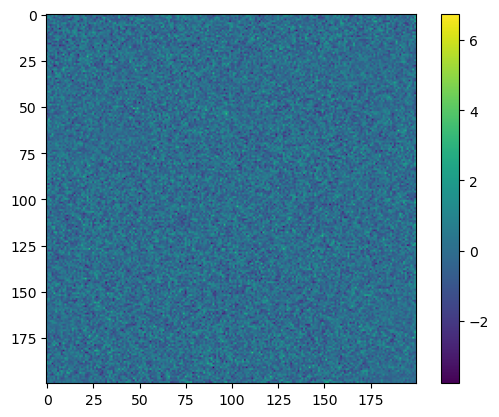

In [151]:
plt.imshow(posterior_v[max_index,:,:]-posterior_v[0,:,:])
plt.colorbar()